# Goal

Implement the mean-shift algorithm
+ Generate sampling points from a 2D Gaussian distribution
+ Generate sampling points from a 2D Mixture of Gassian (MOG) distribution
+ Estimate of generated data via step2 by using Mean-Shift method
+ Plot the clustering results

In [298]:
import torch
import matplotlib.pyplot as plt
import numpy as np

In [156]:
def gaussian(mu, cov, nsample=1):
    if not isinstance(mu, torch.Tensor):
        mu = torch.tensor(mu)
    if not isinstance(cov, torch.Tensor):
        cov = torch.tensor(cov)
    u, d, v = torch.svd(cov)
    sqrt_cov = u @ torch.diag(torch.sqrt(d)) @ v.t()
    samples = torch.randn(nsample, len(mu)) @ sqrt_cov + mu
    return samples

def mix_gaussian(nsample, prior, mu1, cov1, mu2, cov2):
    samples, centers = [], []
    for _ in range(nsample):
        if torch.rand(1).item() < prior[0]: 
            sample = gaussian(mu1, cov1)
            samples.append(sample)
            centers.append(1)
        else:
            sample = gaussian(mu2, cov2)
            samples.append(sample)
            centers.append(0)
    return torch.cat(samples), torch.tensor(centers)

class MainShift:
    def __init__(self, samples, h):
        self.samples = samples
        self.h = h
        self.n, self.d = samples.shape
        
    def kernel(self, x):
        return (2 * torch.pi) ** (-self.d / 2) * torch.exp(-1 / 2 * (x ** 2).sum(dim=-1) / (self.h ** 2))
        
    def grad(self, x):
        x = samples - x
        coef = 2 / (self.n * self.h ** (self.d + 2))
        vector = (self.kernel(x).unsqueeze(-1) * x).sum(dim=0)
        return coef * vector 

## Generate sampling points from a 2D Mixture of Gassian (MOG) distribution

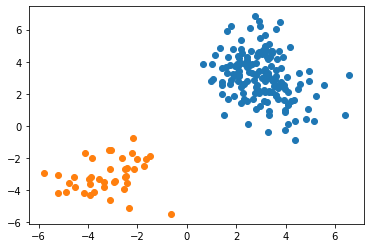

In [254]:
nsample = 200
prior = [0.2, 0.8]
mu1 = [-3, -3]
cov1 = [[2, 0.5], [0.5, 1]]
mu2 = [3, 3]
cov2 = [[1, -0.5], [-0.5, 2]]

samples, centers = mix_gaussian(nsample, prior, mu1, cov1, mu2, cov2)
samples1 = samples[centers == 0] 
samples2 = samples[centers == 1] 
plt.scatter(samples1[:,0], samples1[:,1])
plt.scatter(samples2[:,0], samples2[:,1])

## Main shift clustering result

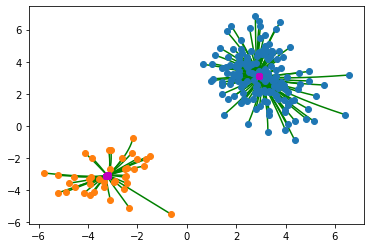

In [297]:
ms = MainShift(samples, 2)
x = samples[1]
cluster = []
for x in samples:
    path = [x]
    for _ in range(2000): 
        grad = ms.grad(x)
        if grad.norm() < 0.0001:
            break
        x = x + grad
        path.append(x)  
    path = np.stack(path)
    plt.plot(path[:, 0], path[:, 1], "g", zorder=0)
    cluster.append(x.numpy())
    
cluster = np.stack(cluster)

plt.scatter(samples1[:, 0], samples1[:, 1])
plt.scatter(samples2[:, 0], samples2[:, 1])
plt.scatter(cluster[:, 0], cluster[:, 1], c="m")